In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.sims.maf.db as db
from lsst.sims.maf.utils import m52snr
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.plots as plots

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
from lsst.sims.utils import equatorialFromGalactic, hpid2RaDec, healbin
from lsst.utils import getPackageDir
import healpy as hp
import os
# Make the notebook repeatable
np.random.seed(42)

In [2]:
def microlensing_amplification(t, impact_parameter=1, crossing_time=1825., peak_time=100):
    """The microlensing amplification
    
    Parameters
    ----------
    t : float
        The time of observation (days)
    impact_parameter : float (1)
        The impact paramter (0 means big amplification)
    crossing_time : float (1825)
        Einstein crossing time (days)
    peak_time : float (100)
        The peak time (days)
    """
    
    lightcurve_u = np.sqrt(impact_parameter**2 + ((t-peak_time)**2/crossing_time**2))    
    amplification = (lightcurve_u**2 + 2)/(lightcurve_u*np.sqrt(lightcurve_u**2 +4))
    
    return amplification
    

In [3]:
t = np.arange(200)
lc = microlensing_amplification(t, crossing_time=500, impact_parameter=0.01)

Text(0, 0.5, 'Amplification')

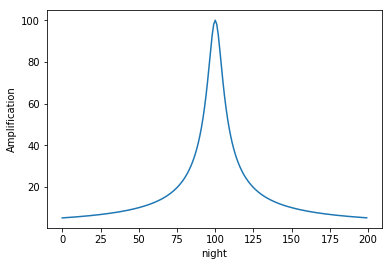

In [4]:
plt.plot(t, lc)
plt.xlabel('night')
plt.ylabel('Amplification')

In [5]:
# Let's make some events
n_events = 10000


In [6]:
mapDir = os.path.join(getPackageDir('sims_maps'), 'TriMaps')
filtername = 'r'
data = np.load(os.path.join(mapDir, 'TRIstarDensity_%s_nside_128.npz' % filtername))
starDensity = data['starDensity'].copy()
# magnitude bins 
bins=data['bins'].copy()
# pixels where there were so many stars some were skipped
mask = data['overMaxMask']
data.close()

/Users/yoachim/lsst/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


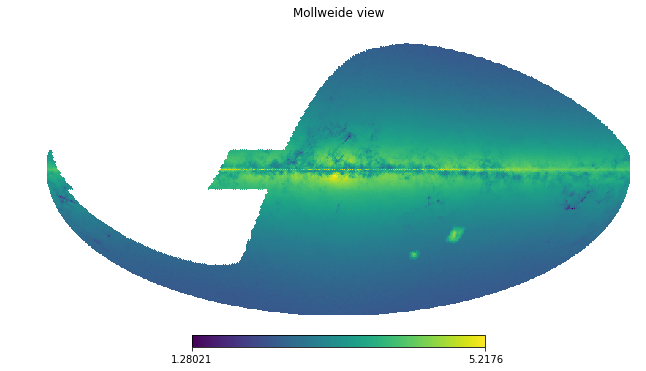

In [7]:
# Note the TRIlegal stellar density map is in nested and galactic coords
hp.mollview(np.log10(starDensity[:,10]), nest=True)

In [8]:
nside = 128
star_mag = 22
bin_indx = np.where(bins[1:] >= star_mag)[0].min()
density_used = starDensity[:,bin_indx].ravel()
order = np.argsort(density_used)
# I think the model might have a few outliers at the extreme, let's truncate it a bit
density_used[order[-10:]] = density_used[order[-11]]

Text(0.5, 0, 'sorted HEALpix ID')

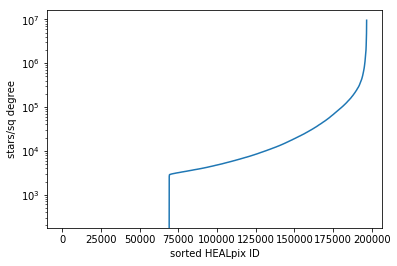

In [9]:
plt.semilogy(density_used[order])
plt.ylabel('stars/sq degree')
plt.xlabel('sorted HEALpix ID')

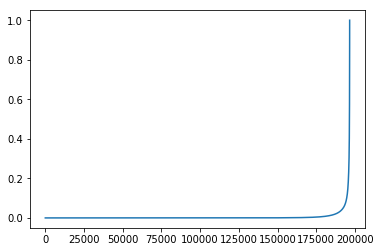

In [10]:
# now, let's draw N from that distribution squared
dist = density_used[order]**2
cumm_dist = np.cumsum(dist)
cumm_dist = cumm_dist/np.max(cumm_dist)
plt.plot(cumm_dist)

In [11]:
uniform_draw = np.random.uniform(size=n_events)
indexes = np.floor(np.interp(uniform_draw, cumm_dist, np.arange(cumm_dist.size)))


In [12]:
hp_ids = order[indexes.astype(int)]
gal_l, gal_b = hpid2RaDec(nside, hp_ids, nest=True)
ra, dec = equatorialFromGalactic(gal_l, gal_b)

/Users/yoachim/lsst/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yoachim/lsst/stack/miniconda3-4.5.12-1172c30/DarwinX86/healpy/1.10.3.lsst2+3/lib/python/healpy-1.10.3-py3.7-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsst/stack/miniconda3-4.5.12-1172c30/DarwinX86/healpy/1.10.3.lsst2+3/lib/python/healpy-1.10.3-py3.7-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsst/stack/miniconda3-4.5.12-1172c30/DarwinX86/healpy/1.10.3.lsst2+3/lib/python/healpy-1.10.3-py3.7-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in 

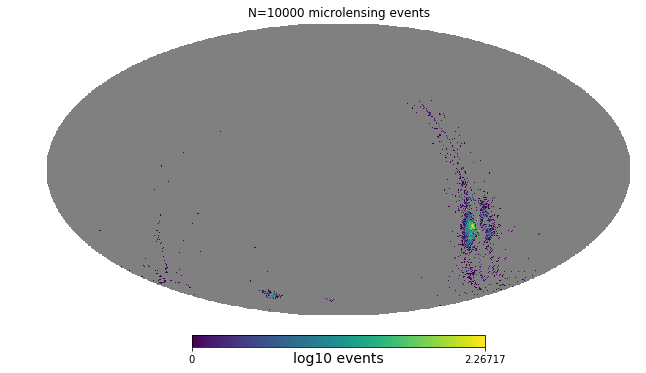

In [13]:
# Let's look at the distribution of our events
event_density = healbin(ra, dec, ra*0+1, nside=128, reduceFunc=np.sum)
hp.mollview(np.log10(event_density), unit='log10 events', title='N=%i microlensing events' % n_events)

In [14]:
# OK, now we have reasonable RA and Dec locations for our N events.
# Let's fill out the other properties we'll need

min_crossing_time = 1 #  Days
max_crossing_time = 100 #1825  # Days

t_start = 1
t_end = 365.25*10.


crossing_times = np.random.uniform(low=min_crossing_time, high=max_crossing_time, size=n_events)
peak_times = np.random.uniform(low=t_start, high=t_end, size=n_events)
impact_paramters = np.random.uniform(low=0, high=1, size=n_events)


In [15]:
# Set up the slicer to evaluate the catalog we just made
slicer = slicers.UserPointsSlicer(ra, dec, latLonDeg=True, badval=0)
# Add any additional information about each object to the slicer
slicer.slicePoints['peak_time'] = peak_times
slicer.slicePoints['crossing_time'] = crossing_times
slicer.slicePoints['impact_parameter'] = impact_paramters

In [16]:
class MicrolensingMetric(metrics.BaseMetric):
    """
    Quantifies detectability of Microlensing events.
    
    Parameters
    ----------
    ptsNeeded : int
        Number of an object's lightcurve points required to be above the 5-sigma limiting depth 
        before it is considered detected.
    
    Notes
    -----
    XXX--describe what slicepoint keys need to be set
    
    """
    def __init__(self, metricName='MicrolensingMetric', mjdCol='observationStartMJD', m5Col='fiveSigmaDepth',
                 filterCol='filter', nightCol='night', ptsNeeded=2, rmag=20, detect_sigma=3., **kwargs):
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.nightCol = nightCol
        self.ptsNeeded = ptsNeeded
        self.detect_sigma = detect_sigma
        # For now, let's just have a flat SED
        # XXX--update to a stellar type
        filters = 'ugrizy'
        self.mags = {}
        for filtername in filters:
            self.mags[filtername] = rmag
        
        
        cols = [self.mjdCol, self.m5Col, self.filterCol, self.nightCol]
        super(MicrolensingMetric, self).__init__(col=cols,
                                                 units='Detected, 0 or 1',
                                                 metricName=metricName,
                                                 **kwargs)
        
    def run(self,  dataSlice, slicePoint=None):
        # Generate the lightcurve for this object
        # make t a kind of simple way
        t = dataSlice[self.mjdCol] - np.min(dataSlice[self.nightCol])
        t = t - t.min()
        
        
        amplitudes = microlensing_amplification(t, impact_parameter=slicePoint['impact_parameter'],
                                                crossing_time=slicePoint['crossing_time'],
                                                peak_time=slicePoint['peak_time'])
        
        filters = np.unique(dataSlice[self.filterCol])
        amplified_mags = amplitudes * 0
        
        for filtername in filters:
            infilt = np.where(dataSlice[self.filterCol] == filtername)[0]
            amplified_mags[infilt] = self.mags[filtername] - 2.5*np.log10(amplitudes[infilt])
        
        # The SNR of each point in the light curve
        snr = m52snr(amplified_mags, dataSlice[self.m5Col])
        # The magnitude uncertainties that go with amplified mags
        mag_uncert = 2.5*np.log10(1+1./snr)
        
        n_pre = []
        for filtername in filters:
            # observations pre-peak and in the given filter
            infilt = np.where((dataSlice[self.filterCol] == filtername) & (t < slicePoint['peak_time']))[0]
            # Broadcast to calc the mag_i - mag_j
            diffs = amplified_mags[infilt] - amplified_mags[infilt][:,np.newaxis]
            diffs_uncert = np.sqrt(mag_uncert[infilt]**2 + mag_uncert[infilt][:, np.newaxis]**2)
            
            # Calculating this as a catalog-level detection. In theory,
            # we could have a high SNR template image, so there would be 
            # little to know additional uncertianty from the subtraction. 
            
            sigma_above = np.abs(diffs)/diffs_uncert
            # divide by 2 because array has i,j and j,i
            n_above = np.size(np.where(sigma_above > self.detect_sigma)[0])/2
            n_pre.append(n_above)
        
        npts = np.sum(n_pre)
        if npts >= self.ptsNeeded:
            return 1
        else:
            return 0

In [17]:
runName = 'baseline_v1.4_10yrs'
#This next command assumes you have downloaded a database into this directory
opsdb = db.OpsimDatabase('baseline_v1.4_10yrs.db')
outDir = 'temp'
resultsDb = db.ResultsDb(outDir=outDir)

metric = MicrolensingMetric()
sql = ''
# Don't want to try and plot N individual points, 
plotDict = {'reduceFunc': np.sum, 'nside': 128}
plotFuncs = [plots.HealpixSkyMap()]
summaryMetrics=[metrics.MeanMetric()]
bundle = metricBundles.MetricBundle(metric, slicer, sql, runName=runName,
                                    plotDict=plotDict, plotFuncs=plotFuncs,
                                    summaryMetrics=summaryMetrics)

Querying database SummaryAllProps with no constraint for columns ['night', 'filter', 'observationStartMJD', 'fiveSigmaDepth', 'fieldRA', 'fieldDec'].
Found 2180589 visits
Running:  ['baseline_v1_4_10yrs_MicrolensingMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.


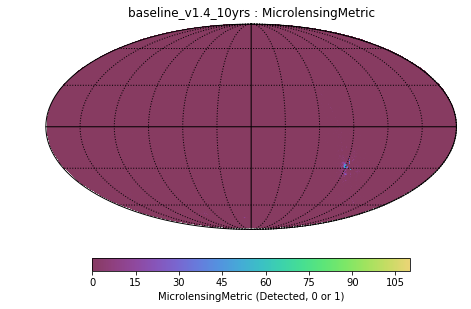

In [18]:
bgroup = metricBundles.MetricBundleGroup([bundle], opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [19]:
print('fraction of events detected pre-peak=', bundle.summaryValues['Mean'])

fraction of events detected pre-peak= 0.5600040036032429


/Users/yoachim/git_repos/sims_utils/python/lsst/sims/utils/healpyUtils.py:142: UserWarning: Warning: converting a masked element to nan.
  mapVals[idx] = reduceFunc(values[left[i]:right[i]])


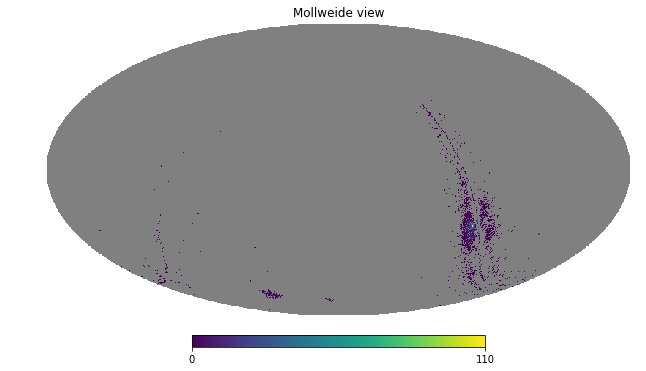

In [20]:
hp.mollview(healbin(ra, dec, bundle.metricValues, reduceFunc=np.sum))

In [21]:
bundle.metricValues.data.sum()

5595.0